# Dog Memorizer GAN
## DISCLAIMER: This may not be a valid comp solution
In this kernel we attempt to create a new kind of semi-supervised GAN. (Typical GAN design is presented in Nanashi's great tutorial [here][4]). Instead of having the Generator and Discriminator learn at the same time, we will first train the Discriminator to memorize all the training images. Next the Discriminator will teach the images to the Generator. We give the Generator poor memory (with a bottleneck) in hopes that it will learn to generalize. For our Kaggle submission, we will ask this Generator to output a mixture of (the generalized) images it has learned. Since the images are stored in a conv net, we hope to get a generalized conceptual mixture (versus a pixel blend). (This kernel is inspired by the tutorial [here][1] and by my previous kernels [here][2] and [here][3]).

![image](http://playagricola.com/Kaggle/gan7419.png)

A GAN consists of a Generator and Discriminator. After being trained, a Generator is a robot artist that draws dog images. During training the Discriminator teaches the Generator how to draw a dog. (And typically the G teaches the D to disguish real from fake dogs). The Generator never sees any images of dogs. Instead it continually attempts to draw a dog and is coached by the Discriminator. In this kernel, the **Memorizer** Generator is coached to memorize images from the training set. (We hope generalization arises from poor memory). In contrast, a **Generalizing** Generator is coached to generalize images!

# Load and Crop Images

[1]: https://medium.com/datadriveninvestor/generative-adversarial-network-gan-using-keras-ce1c05cfdfd3
[2]: https://www.kaggle.com/cdeotte/dog-autoencoder
[3]: https://www.kaggle.com/cdeotte/supervised-generative-dog-net
[4]: https://www.kaggle.com/jesucristo/gan-introduction

In [1]:
ComputeLB = True
DogsOnly = True
import sklearn
import shutil
from sklearn.model_selection import train_test_split
import numpy as np, pandas as pd, os
import xml.etree.ElementTree as ET 
import matplotlib.pyplot as plt, zipfile 
from PIL import Image 
ROOT = '../input/generative-dog-images/'




if not ComputeLB: ROOT = '../input/'
IMAGES = os.listdir(ROOT + 'all-dogs/all-dogs/')
breeds = os.listdir(ROOT + 'annotation/Annotation/') 

idxIn = 0; namesIn = []
imagesIn = np.zeros((25000,img_size,img_size,3))

# CROP WITH BOUNDING BOXES TO GET DOGS ONLY
# https://www.kaggle.com/paulorzp/show-annotations-and-breeds
if DogsOnly:
    for breed in breeds:
        for dog in os.listdir(ROOT+'annotation/Annotation/'+breed):
            try: img = Image.open(ROOT+'all-dogs/all-dogs/'+dog+'.jpg') 
            except: continue           
            tree = ET.parse(ROOT+'annotation/Annotation/'+breed+'/'+dog)
            root = tree.getroot()
            objects = root.findall('object')
            for o in objects:
                bndbox = o.find('bndbox') 
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                w = np.min((xmax - xmin, ymax - ymin))
                img2 = img.crop((xmin, ymin, xmin+w, ymin+w))
                img2 = img2.resize((img_size,img_size), Image.ANTIALIAS)
                imagesIn[idxIn,:,:,:] = np.asarray(img2)
                #if idxIn%1000==0: print(idxIn)
                namesIn.append(breed)
                idxIn += 1
    idx = np.arange(idxIn)
    np.random.shuffle(idx)
    imagesIn = imagesIn[idx,:,:,:]
    namesIn = np.array(namesIn)[idx]
    
# RANDOMLY CROP FULL IMAGES
else:
    x = np.random.choice(np.arange(20579),size_discriminator)
    for k in range(len(x)):
        img = Image.open(ROOT + 'all-dogs/all-dogs/' + IMAGES[x[k]])
        w = img.size[0]
        h = img.size[1]
        sz = np.min((w,h))
        a=0; b=0
        if w<h: b = (h-sz)//2
        else: a = (w-sz)//2
        img = img.crop((0+a, 0+b, sz+a, sz+b))  
        img = img.resize((img_size,img_size), Image.ANTIALIAS)   
        imagesIn[idxIn,:,:,:] = np.asarray(img)
        namesIn.append(IMAGES[x[k]])
        if idxIn%1000==0: print(idxIn)
        idxIn += 1
    
# DISPLAY CROPPED IMAGES
x = np.random.randint(0,idxIn,25)
for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        plt.subplot(1,5,j+1)
        img = Image.fromarray( imagesIn[x[k*5+j],:,:,:].astype('uint8') )
        plt.axis('off')
        if not DogsOnly: plt.title(namesIn[x[k*5+j]],fontsize=11)
        else: plt.title(namesIn[x[k*5+j]].split('-')[1],fontsize=11)
        plt.imshow(img)
    plt.show()

# Build Discriminator

In [2]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Reshape, Flatten, concatenate, UpSampling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD, Adam

Using TensorFlow backend.


In [3]:
size_4_training=7142
size_4_training0=size_4_training
size_4_training1=size_4_training
size_4_training_total=size_4_training0+size_4_training1
size_discriminator=int(size_4_training_total*0.7)
print(size_discriminator)
img_size=50
img_size_flatten=img_size*img_size*3
sampling_seed = 0
epoch_4_test = 50

9998


# Read in Breast Cancer Images

In [4]:
import os
os.makedirs('../working/data/train_seg/idc-minus/')     
os.makedirs('../working/data/train_seg/idc-plus/')  
os.makedirs('../working/data/test_seg/idc-minus/')     
os.makedirs('../working/data/test_seg/idc-plus/')  
os.makedirs('../working/data/val_seg/idc-minus/')     
os.makedirs('../working/data/val_seg/idc-plus/') 

In [5]:
import random
from glob import glob
imagePatches = glob('../input/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive=True)
train_dir='../working/data/train_seg/'
validation_dir='../working/data/val_seg/'
#train_dir='../working/data/train_seg/'  
#test_dir = '../working/data/test_seg/normal'  
test_dir = '../working/data/test_seg/'  

class0 = [] # 0 = idc+
class1 = [] # 1 = idc-
imagePatches = glob('../input/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive=True)
for filename in imagePatches:
    if filename.endswith("class0.png"):
         class0.append(filename)
    else:
        class1.append(filename)

print(class0[0:10])

#sampling 10000 images from class 0 and class 1 to train the model

random.seed(sampling_seed)
class0sample=random.sample(class0,size_4_training0)
class0label=np.zeros(size_4_training0)
class1sample=random.sample(class1,size_4_training1)
class1label=np.ones(size_4_training1)

class0sample_train, class0sample_test1, class0label_train, class0label_test1 = train_test_split(class0sample, class0label, test_size=0.3, random_state=42)
class0sample_val, class0sample_test,  class0label_val, class0label_test = train_test_split(class0sample_test1, class0label_test1, test_size=0.3, random_state=42)
print(len(class0sample_train))
print(len(class0sample_test))
print(len(class0sample_val))
class1sample_train, class1sample_test1, class1label_train, class1label_test1 = train_test_split(class1sample, class1label, test_size=0.3, random_state=42)
class1sample_val, class1sample_test, class1label_val, class1label_test = train_test_split(class1sample_test1, class1label_test1, test_size=0.3, random_state=42)
print(len(class1sample_train))
print(len(class1sample_test))
print(len(class1sample_val))
def read_and_save_data(path, file_name_array):
    j=0
    for i in file_name_array:
        if i.endswith('.png'):
          
            
            #second copy method
            head, tail = os.path.split(i)
            outputname=str(path+tail)
            #outputname=str(path+str(j)+'.png')
            #print(outputname)

            shutil.copy(i, outputname)
             
            #print(status2)
            
            j=j+1
            if j==120000:
                break
            
   
class0train_path='../working/data/train_seg/idc-minus/'
class1train_path='../working/data/train_seg/idc-plus/'
class0test_path='../working/data/test_seg/idc-minus/'
class1test_path='../working/data/test_seg/idc-plus/'
class0val_path='../working/data/val_seg/idc-minus/'
class1val_path='../working/data/val_seg/idc-plus/'

read_and_save_data(class0train_path,class0sample_train)
read_and_save_data(class1train_path,class1sample_train)


read_and_save_data(class0test_path,class0sample_test)
read_and_save_data(class1test_path,class1sample_test)


read_and_save_data(class0val_path,class0sample_val)
read_and_save_data(class1val_path,class1sample_val)

['../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1351_y1101_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y501_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y1101_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x451_y901_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x801_y451_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x151_y1051_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1351_y901_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x701_y651_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x951_y1401_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/102

In [6]:
import os #Operating System
import sys #System
import cv2
def readImage(path, tag):
    j=0
    image_data = []
    label=[]
    for i in os.listdir(path):
        imgname=path+i
        #print(imgname)
        img = cv2.imread(imgname, cv2.IMREAD_COLOR)
        img_resized = cv2.resize(img, (img_size,img_size), interpolation=cv2.INTER_LINEAR)
        image_data.append(img_resized)
        label.append(tag)
        #print(img[1])
        j=j+1
        #if j==10:
        #    break
        
    return image_data, label

import numpy as np
from tensorflow.keras.utils import *
from sklearn.utils import shuffle

class0_train, train0_label = readImage(class0train_path, 0)
class1_train, train1_label  = readImage(class1train_path, 1)
class0_test, test0_label = readImage(class0test_path, 0)
class1_test, test1_label = readImage(class1test_path, 1)
class0_val, val0_label = readImage(class0val_path, 0)
class1_val, val1_label = readImage(class1val_path, 1)

def Image_array_process(class0array,label0, class1array, label1):
    class0_array=np.array(class0array)
    class1_array=np.array(class1array)
    combined_data = np.concatenate((class0_array, class1_array))
    combined_label= np.concatenate((label0,label1), axis=0)
    assert len(combined_data) == len(combined_label)
    combined_data, combined_label = shuffle(combined_data, combined_label, random_state=0)
    print(combined_data.shape)
    length=len(combined_data)
    combined_label=to_categorical(combined_label,num_classes=2)
    #i=0
    #for i in range(length):
    #    print(combined_label[i])

    #print

    #print(class0_array.shape)
    #print(combined_data.shape)
    '''
    training_reshape=(224,224,3)
    length=len(combined_data)
    print(length)
    x =[None]*length
    #print(img_data.type)
    y =np.zeros(length)
    i=0
   
    for features,label in combined_data:
        x[i]=features
        #print(x.shape)
        y[i]=label
        #print(y[i])
        i=i+1
    
            #x = np.array(x).reshape(training_reshape)
    x = np.array(x)    
    #print(x.shape)
    #y=np.array(y)
    y=y.astype(int)
    y = to_categorical(y)
    print(y)
    '''  
    return combined_data, combined_label


X_train, y_train=Image_array_process(class0_train, train0_label, class1_train, train1_label)
X_test, y_test=Image_array_process(class0_test, test0_label, class1_test, test1_label)
X_val, y_val=Image_array_process(class0_val, val0_label, class1_val, val1_label)
#imagesIn, y_total=Image_array_process(class0sample, class0label, class1sample, class1label)
imagesIn=X_train

(9998, 50, 50, 3)
(1286, 50, 50, 3)
(3000, 50, 50, 3)


In [7]:
size_discriminator=int(size_4_training_total*0.7)
# BUILD DISCRIMINATIVE NETWORK
dog = Input((img_size_flatten,))
#Explain: 12288 is the total data size of the img: img_sizeximg_sizex3=12288
dogName = Input((size_discriminator,))
x = Dense(img_size_flatten, activation='sigmoid')(dogName) 
x = Reshape((2,img_size_flatten,1))(concatenate([dog,x]))
x = Conv2D(1,(2,1),use_bias=False,name='conv')(x)
discriminated = Flatten()(x)

# COMPILE
discriminator = Model([dog,dogName], discriminated)
discriminator.get_layer('conv').trainable = False
discriminator.get_layer('conv').set_weights([np.array([[[[-1.0 ]]],[[[1.0]]]])])
discriminator.compile(optimizer='adam', loss='binary_crossentropy')

# DISPLAY ARCHITECTURE
discriminator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 9998)         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 7500)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 7500)         74992500    input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 15000)        0           input_1[0][0]                    
                                                                 dense_1[0][0]                    
__________

# Train Discriminator
We will train the Discriminator to memorize the training images. (Typically you don't train the Discriminator ahead of time. The D learns as the G learns. But this GAN is special).

In [8]:

print(imagesIn.shape)
#print(X_train)

(9998, 50, 50, 3)


In [9]:
# TRAINING DATA

train_y = (imagesIn[:size_discriminator,:,:,:]/255.).reshape((-1,img_size_flatten))
train_X = np.zeros((size_discriminator,size_discriminator))
for i in range(size_discriminator): train_X[i,i] = 1
zeros = np.zeros((size_discriminator,img_size_flatten))

# TRAIN NETWORK
lr = 0.5
for k in range(5):
    annealer = LearningRateScheduler(lambda x: lr)
    h = discriminator.fit([zeros,train_X], train_y, epochs = 10, batch_size=256, callbacks=[annealer], verbose=0)
    print('Epoch',(k+1)*10,'/30 - loss =',h.history['loss'][-1] )
    if h.history['loss'][-1]<0.533: lr = 0.1

Epoch 10 /30 - loss = 0.5244206182120633
Epoch 20 /30 - loss = 0.5218860560427858
Epoch 30 /30 - loss = 0.5210137129139962
Epoch 40 /30 - loss = 0.5205913423108778
Epoch 50 /30 - loss = 0.5203839426017757


# Delete Training Images
Our Discriminator has memorized all the training images. We will now delete the training images. Our Generator will never see the training images. It will only be coached by the Discriminator. Below are examples of images that the Discriminator memorized.

In [10]:
del train_X, train_y, imagesIn

Discriminator Recalls from Memory Dogs


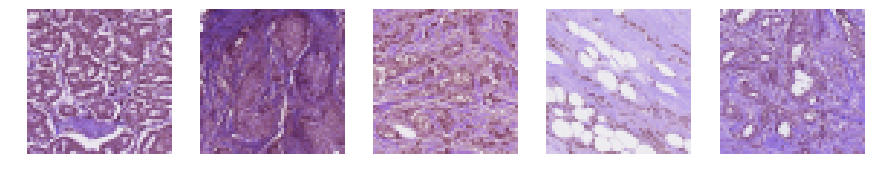

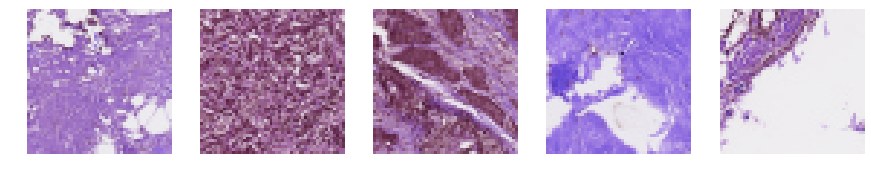

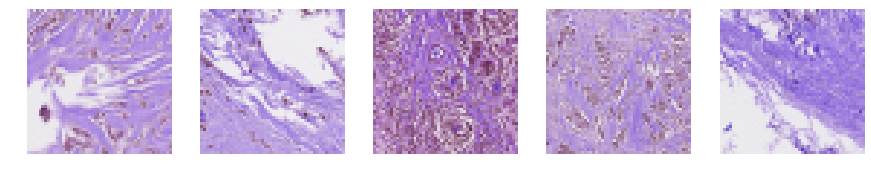

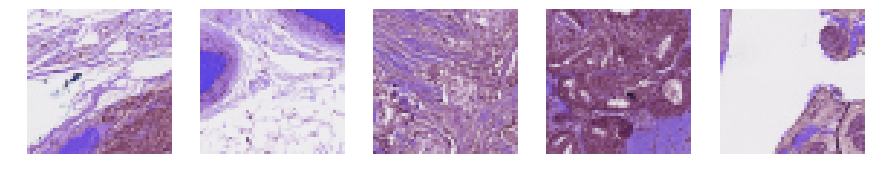

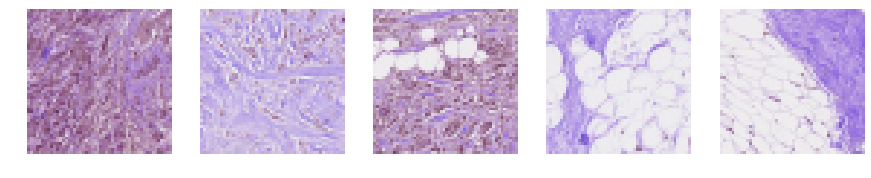

In [11]:
print('Discriminator Recalls from Memory Dogs')    
for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        xx = np.zeros((size_discriminator))
        xx[np.random.randint(size_discriminator)] = 1
        plt.subplot(1,5,j+1)
        img = discriminator.predict([zeros[0,:].reshape((-1,img_size_flatten)),xx.reshape((-1,size_discriminator))]).reshape((-1,img_size,img_size,3))
        img = Image.fromarray( (255*img).astype('uint8').reshape((img_size,img_size,3)))
        plt.axis('off')
        plt.imshow(img)
    plt.show()

# Build Generator and GAN
We will purposely give our Generator a bottleneck in its memory. Using poor memory forces the Generator to learn a generalization of images and not memorize the images exactly.

In [16]:
# BUILD GENERATOR NETWORK
BadMemory = True

if BadMemory:
    seed = Input((size_discriminator,))
#Q: is seed the number of image input
    x = Dense(3200, activation='elu')(seed)
    x = Reshape((10,10,32))(x)
    x = Conv2D(128, (3, 3), activation='elu', padding='same')(x)
    x = UpSampling2D((5, 5))(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same')(x)
    #x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='elu', padding='same')(x)
    #x = UpSampling2D((2, 2))(x)
    x = Conv2D(3, (3, 3), activation='linear', padding='same')(x)
    generated = Flatten()(x)
else:
    seed = Input((size_discriminator,))
    generated = Dense(img_size_flatten, activation='linear')(seed)

# COMPILE
generator = Model(seed, [generated,Reshape((size_discriminator,))(seed)])

# DISPLAY ARCHITECTURE
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 9998)         0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 3200)         31996800    input_8[0][0]                    
__________________________________________________________________________________________________
reshape_11 (Reshape)            (None, 10, 10, 32)   0           dense_7[0][0]                    
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 10, 10, 128)  36992       reshape_11[0][0]                 
__________________________________________________________________________________________________
up_samplin

In [17]:
# BUILD GENERATIVE ADVERSARIAL NETWORK
discriminator.trainable=False    
gan_input = Input(shape=(size_discriminator,))
x = generator(gan_input)
gan_output = discriminator(x)

# COMPILE GAN
gan = Model(gan_input, gan_output)
gan.get_layer('model_1').get_layer('conv').set_weights([np.array([[[[-1 ]]],[[[255.]]]])])
gan.compile(optimizer=Adam(5), loss='mean_squared_error')

# DISPLAY ARCHITECTURE
gan.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 9998)         0                                            
__________________________________________________________________________________________________
model_6 (Model)                 [(None, 7500), (None 32126915    input_9[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 7500)         74992502    model_6[1][0]                    
                                                                 model_6[1][1]                    
Total params: 107,119,417
Trainable params: 32,126,915
Non-trainable params: 74,992,502
__________________________________________________________________________________________________


# Discriminator Coaches Generator
In a typical GAN, the discriminator does not memorize the training images beforehand. Instead it learns to distinquish real images from fake images at the same time that the Generator learns to make fake images. In this GAN, we taught the Discriminator ahead of time and it will now teach the Generator.

Epoch 1 /9 - loss = 8376.771112034907


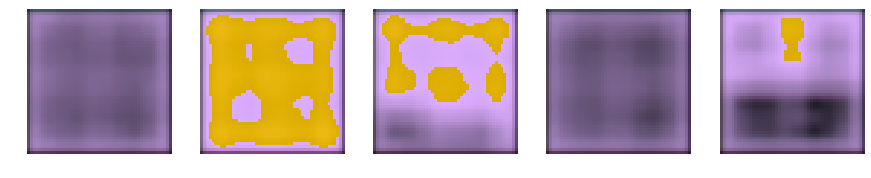

Epoch 2 /9 - loss = 1715.3099650691856


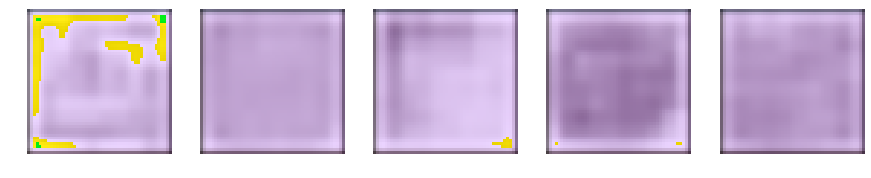

Epoch 3 /9 - loss = 813.517292875079


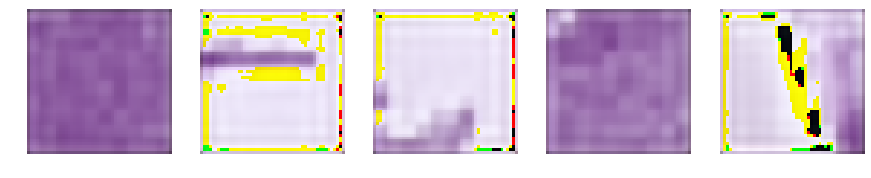

Epoch 4 /9 - loss = 505.22231068528157


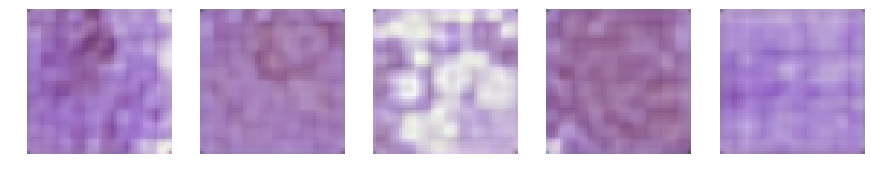

Epoch 5 /9 - loss = 385.1473004622897


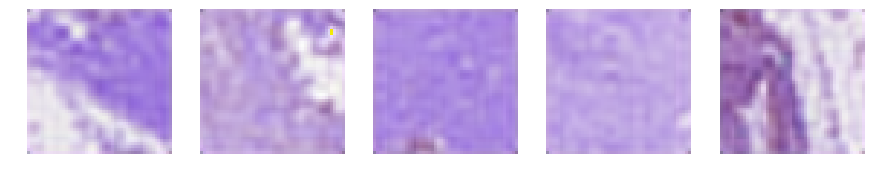

Epoch 6 /9 - loss = 316.89360662049404


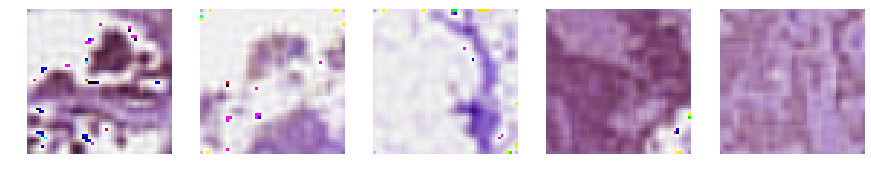

Epoch 7 /9 - loss = 224.44452126814522


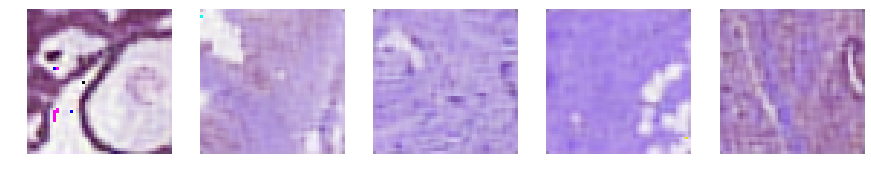

Epoch 8 /9 - loss = 116.97759960012021


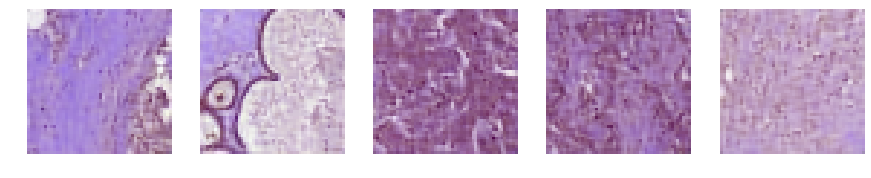

Epoch 9 /9 - loss = 44.5284454817294


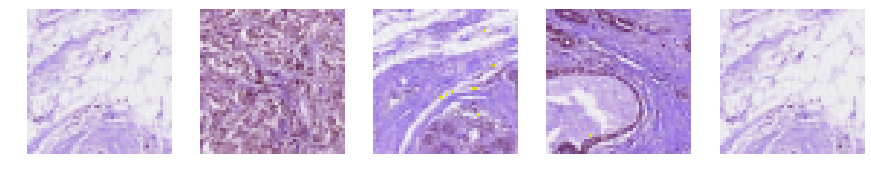

In [18]:
# TRAINING DATA
train = np.zeros((size_discriminator,size_discriminator))
for i in range(size_discriminator): train[i,i] = 1
zeros = np.zeros((size_discriminator,img_size_flatten))

# TRAIN NETWORKS
ep = 1; it = 9
if BadMemory: lr = 0.005
else: lr = 5.
    
for k in range(it):  

    # BEGIN DISCRIMINATOR COACHES GENERATOR
    annealer = LearningRateScheduler(lambda x: lr)
    h = gan.fit(train, zeros, epochs = ep, batch_size=256, callbacks=[annealer], verbose=0)

    # DISPLAY GENERATOR LEARNING PROGRESS 
    print('Epoch',(k+1),'/'+str(it)+' - loss =',h.history['loss'][-1] )
    plt.figure(figsize=(15,3))
    for j in range(5):
        xx = np.zeros((size_discriminator))
        xx[np.random.randint(size_discriminator)] = 1
        plt.subplot(1,5,j+1)
        img = generator.predict(xx.reshape((-1,size_discriminator)))[0].reshape((-1,img_size,img_size,3))
        img = Image.fromarray( (img).astype('uint8').reshape((img_size,img_size,3)))
        plt.axis('off')
        plt.imshow(img)
    plt.show()  
            
    # ADJUST LEARNING RATES
    if BadMemory:
        ep *= 2
        if ep>=32: lr = 0.001
        if ep>256: ep = 256
    else:
        if h.history['loss'][-1] < 25: lr = 1.
        if h.history['loss'][-1] < 1.5: lr = 0.5

# Build Generator Class
Our Generative Network has now learned all the training images from our Discriminative Network. With its poor memory, we hope that it has learned to generalize somewhat. Now let's build a Generator Class that accepts any random 100 dimensional vector and outputs an image. Our class will return 70% of one "memorized" image mixed with 30% another. Since the images are stored in a convolutional network, we hope that it makes a generalized conceptual mixture (versus a pixel blend).

In [20]:
class DogGenerator:
    index = 0   
    def getDog(self,seed):
        xx = np.zeros((size_discriminator))
        xx[self.index] = 0.70
        xx[np.random.randint(size_discriminator)] = 0.30
        img = generator.predict(xx.reshape((-1,size_discriminator)))[0].reshape((img_size,img_size,3))
        self.index = (self.index+1)%size_discriminator
        return Image.fromarray( img.astype('uint8') ) 

# Examples of Generated Dogs

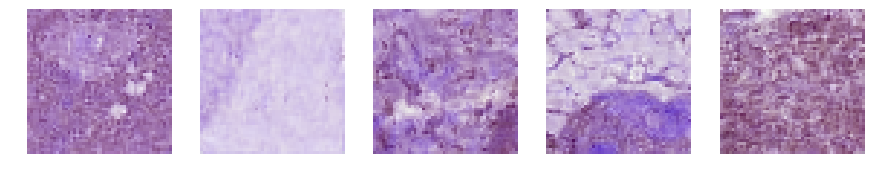

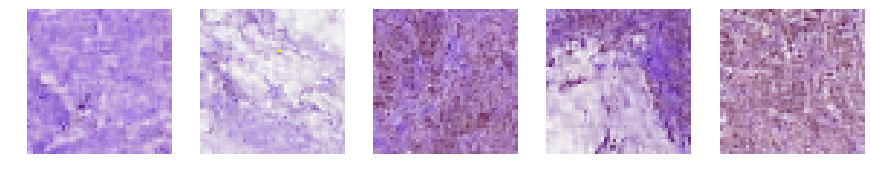

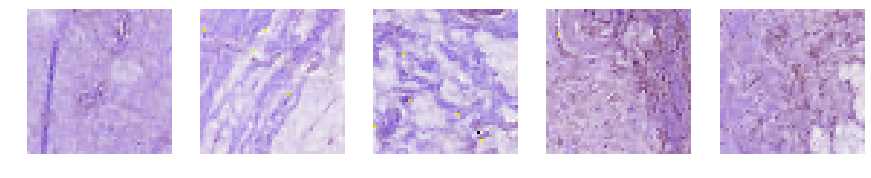

In [21]:
# DISPLAY EXAMPLE DOGS
d = DogGenerator()
for k in range(3):
    plt.figure(figsize=(15,3))
    for j in range(5):
        plt.subplot(1,5,j+1)
        img = d.getDog(np.random.normal(0,1,100))
        plt.axis('off')
        plt.imshow(img)
    plt.show() 

# Submit to Kaggle
In this kernel we learned how to make an experimental GAN. Currently it scores around LB 100. We must be careful as we try to improve its score. If we give this GAN excellent memory and request a mixture of 99.9% one image and 0.1% another, then it can score LB 7 but then it is returning "altered versions" of images and violates the rules [here][1]

[1]: https://www.kaggle.com/c/generative-dog-images/discussion/98183

In [22]:
# SAVE TO ZIP FILE NAMED IMAGES.ZIP
z = zipfile.PyZipFile('images.zip', mode='w')
d = DogGenerator()
for k in range(size_discriminator):
    img = d.getDog(np.random.normal(0,1,100))
    f = str(k)+'.png'
    img.save(f,'PNG'); z.write(f); os.remove(f)
    #if k % 1000==0: print(k)
z.close()

# Calculate LB Score
If you wish to compute LB, you must add the LB metric dataset [here][1] to this kernel and change the boolean variable in the first cell block.

[1]: https://www.kaggle.com/wendykan/dog-face-generation-competition-kid-metric-input

In [25]:
from __future__ import absolute_import, division, print_function
import numpy as np
import os
import gzip, pickle
import tensorflow as tf
from scipy import linalg
import pathlib
import urllib
import warnings
from tqdm import tqdm
from PIL import Image

class KernelEvalException(Exception):
    pass

model_params = {
    'Inception': {
        'name': 'Inception', 
        'imsize': img_size,
        'output_layer': 'Pretrained_Net/pool_3:0', 
        'input_layer': 'Pretrained_Net/ExpandDims:0',
        'output_shape': 2048,
        'cosine_distance_eps': 0.1
        }
}

def create_model_graph(pth):
    """Creates a graph from saved GraphDef file."""
    # Creates graph from saved graph_def.pb.
    with tf.gfile.FastGFile( pth, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString( f.read())
        _ = tf.import_graph_def( graph_def, name='Pretrained_Net')

def _get_model_layer(sess, model_name):
    # layername = 'Pretrained_Net/final_layer/Mean:0'
    layername = model_params[model_name]['output_layer']
    layer = sess.graph.get_tensor_by_name(layername)
    ops = layer.graph.get_operations()
    for op_idx, op in enumerate(ops):
        for o in op.outputs:
            shape = o.get_shape()
            if shape._dims != []:
              shape = [s.value for s in shape]
              new_shape = []
              for j, s in enumerate(shape):
                if s == 1 and j == 0:
                  new_shape.append(None)
                else:
                  new_shape.append(s)
              o.__dict__['_shape_val'] = tf.TensorShape(new_shape)
    return layer

def get_activations(images, sess, model_name, batch_size=50, verbose=False):
    """Calculates the activations of the pool_3 layer for all images.

    Params:
    -- images      : Numpy array of dimension (n_images, hi, wi, 3). The values
                     must lie between 0 and 256.
    -- sess        : current session
    -- batch_size  : the images numpy array is split into batches with batch size
                     batch_size. A reasonable batch size depends on the disposable hardware.
    -- verbose    : If set to True and parameter out_step is given, the number of calculated
                     batches is reported.
    Returns:
    -- A numpy array of dimension (num images, 2048) that contains the
       activations of the given tensor when feeding inception with the query tensor.
    """
    inception_layer = _get_model_layer(sess, model_name)
    n_images = images.shape[0]
    if batch_size > n_images:
        print("warning: batch size is bigger than the data size. setting batch size to data size")
        batch_size = n_images
    n_batches = n_images//batch_size + 1
    pred_arr = np.empty((n_images,model_params[model_name]['output_shape']))
    for i in tqdm(range(n_batches)):
        if verbose:
            print("\rPropagating batch %d/%d" % (i+1, n_batches), end="", flush=True)
        start = i*batch_size
        if start+batch_size < n_images:
            end = start+batch_size
        else:
            end = n_images
                    
        batch = images[start:end]
        pred = sess.run(inception_layer, {model_params[model_name]['input_layer']: batch})
        pred_arr[start:end] = pred.reshape(-1,model_params[model_name]['output_shape'])
    if verbose:
        print(" done")
    return pred_arr


# def calculate_memorization_distance(features1, features2):
#     neigh = NearestNeighbors(n_neighbors=1, algorithm='kd_tree', metric='euclidean')
#     neigh.fit(features2) 
#     d, _ = neigh.kneighbors(features1, return_distance=True)
#     print('d.shape=',d.shape)
#     return np.mean(d)

def normalize_rows(x: np.ndarray):
    """
    function that normalizes each row of the matrix x to have unit length.

    Args:
     ``x``: A numpy matrix of shape (n, m)

    Returns:
     ``x``: The normalized (by row) numpy matrix.
    """
    return np.nan_to_num(x/np.linalg.norm(x, ord=2, axis=1, keepdims=True))


def cosine_distance(features1, features2):
    # print('rows of zeros in features1 = ',sum(np.sum(features1, axis=1) == 0))
    # print('rows of zeros in features2 = ',sum(np.sum(features2, axis=1) == 0))
    features1_nozero = features1[np.sum(features1, axis=1) != 0]
    features2_nozero = features2[np.sum(features2, axis=1) != 0]
    norm_f1 = normalize_rows(features1_nozero)
    norm_f2 = normalize_rows(features2_nozero)

    d = 1.0-np.abs(np.matmul(norm_f1, norm_f2.T))
    print('d.shape=',d.shape)
    print('np.min(d, axis=1).shape=',np.min(d, axis=1).shape)
    mean_min_d = np.mean(np.min(d, axis=1))
    print('distance=',mean_min_d)
    return mean_min_d


def distance_thresholding(d, eps):
    if d < eps:
        return d
    else:
        return 1

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
            
    Stable version by Dougal J. Sutherland.

    Params:
    -- mu1 : Numpy array containing the activations of the pool_3 layer of the
             inception net ( like returned by the function 'get_predictions')
             for generated samples.
    -- mu2   : The sample mean over activations of the pool_3 layer, precalcualted
               on an representive data set.
    -- sigma1: The covariance matrix over activations of the pool_3 layer for
               generated samples.
    -- sigma2: The covariance matrix over activations of the pool_3 layer,
               precalcualted on an representive data set.

    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, "Training and test mean vectors have different lengths"
    assert sigma1.shape == sigma2.shape, "Training and test covariances have different dimensions"

    diff = mu1 - mu2

    # product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = "fid calculation produces singular product; adding %s to diagonal of cov estimates" % eps
        warnings.warn(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        # covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
    
    # numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError("Imaginary component {}".format(m))
        covmean = covmean.real

    # covmean = tf.linalg.sqrtm(tf.linalg.matmul(sigma1,sigma2))

    print('covmean.shape=',covmean.shape)
    # tr_covmean = tf.linalg.trace(covmean)

    tr_covmean = np.trace(covmean)
    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean
    # return diff.dot(diff) + tf.linalg.trace(sigma1) + tf.linalg.trace(sigma2) - 2 * tr_covmean
#-------------------------------------------------------------------------------


def calculate_activation_statistics(images, sess, model_name, batch_size=50, verbose=False):
    """Calculation of the statistics used by the FID.
    Params:
    -- images      : Numpy array of dimension (n_images, hi, wi, 3). The values
                     must lie between 0 and 255.
    -- sess        : current session
    -- batch_size  : the images numpy array is split into batches with batch size
                     batch_size. A reasonable batch size depends on the available hardware.
    -- verbose     : If set to True and parameter out_step is given, the number of calculated
                     batches is reported.
    Returns:
    -- mu    : The mean over samples of the activations of the pool_3 layer of
               the incption model.
    -- sigma : The covariance matrix of the activations of the pool_3 layer of
               the incption model.
    """
    act = get_activations(images, sess, model_name, batch_size, verbose)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma, act
    
def _handle_path_memorization(path, sess, model_name, is_checksize, is_check_png):
    path = pathlib.Path(path)
    files = list(path.glob('*.jpg')) + list(path.glob('*.png'))
    imsize = model_params[model_name]['imsize']

    # In production we don't resize input images. This is just for demo purpose. 
    x = np.array([np.array(img_read_checks(fn, imsize, is_checksize, imsize, is_check_png)) for fn in files])
    m, s, features = calculate_activation_statistics(x, sess, model_name)
    del x #clean up memory
    return m, s, features

# check for image size
def img_read_checks(filename, resize_to, is_checksize=False, check_imsize = img_size, is_check_png = False):
    im = Image.open(str(filename))
    if is_checksize and im.size != (check_imsize,check_imsize):
        raise KernelEvalException('The images are not of size '+str(check_imsize))
    
    if is_check_png and im.format != 'PNG':
        raise KernelEvalException('Only PNG images should be submitted.')

    if resize_to is None:
        return im
    else:
        return im.resize((resize_to,resize_to),Image.ANTIALIAS)

def calculate_kid_given_paths(paths, model_name, model_path, feature_path=None, mm=[], ss=[], ff=[]):
    ''' Calculates the KID of two paths. '''
    tf.reset_default_graph()
    create_model_graph(str(model_path))
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        m1, s1, features1 = _handle_path_memorization(paths[0], sess, model_name, is_checksize = True, is_check_png = True)
        if len(mm) != 0:
            m2 = mm
            s2 = ss
            features2 = ff
        elif feature_path is None:
            m2, s2, features2 = _handle_path_memorization(paths[1], sess, model_name, is_checksize = False, is_check_png = False)
        else:
            with np.load(feature_path) as f:
                m2, s2, features2 = f['m'], f['s'], f['features']

        print('m1,m2 shape=',(m1.shape,m2.shape),'s1,s2=',(s1.shape,s2.shape))
        print('starting calculating FID')
        fid_value = calculate_frechet_distance(m1, s1, m2, s2)
        print('done with FID, starting distance calculation')
        distance = cosine_distance(features1, features2)        
        return fid_value, distance, m2, s2, features2

In [26]:
if ComputeLB:
  
    # UNCOMPRESS OUR IMGAES
    with zipfile.ZipFile("../working/images.zip","r") as z:
        z.extractall("../tmp/images2/")

    # COMPUTE LB SCORE
    m2 = []; s2 =[]; f2 = []
    user_images_unzipped_path = '../tmp/images2/'
    images_path = [user_images_unzipped_path,'../input/generative-dog-images/all-dogs/all-dogs/']
    public_path = '../input/dog-face-generation-competition-kid-metric-input/classify_image_graph_def.pb'

    fid_epsilon = 10e-15

    fid_value_public, distance_public, m2, s2, f2 = calculate_kid_given_paths(images_path, 'Inception', public_path, mm=m2, ss=s2, ff=f2)
    distance_public = distance_thresholding(distance_public, model_params['Inception']['cosine_distance_eps'])
    print("FID_public: ", fid_value_public, "distance_public: ", distance_public, "multiplied_public: ",
            fid_value_public /(distance_public + fid_epsilon))
    
    # REMOVE FILES TO PREVENT KERNEL ERROR OF TOO MANY FILES
    ! rm -r ../tmp

100%|██████████| 200/200 [00:35<00:00,  3.58it/s]


ZeroDivisionError: integer division or modulo by zero